# Extraction of Spindles from Neocortex recordings

Restarting from LFPwake0 and LFPwakeremoved.

LFPwakeremoved will be used to determined signal variance for threshold adjustement. 

LFPwake0 will be used for time determination. 

## Load LFP and packages

In [1]:
from scipy import signal, stats
from scipy.signal import find_peaks, peak_widths
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
from ipyfilechooser import FileChooser
import ipywidgets as widgets

%matplotlib widget
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, CsvEpochSource, EpochEncoder,EpochViewer,InMemoryEventSource,EventList
from ephyviewer import AnalogSignalSourceWithScatter
from ephyviewer import InMemoryAnalogSignalSource
import ephyviewer

from mbTools import mbTools

In [2]:
dpath = ""
try:
    %store -r dpath
except:
    print("data path not in strore")
    dpath = os.path.expanduser("~")

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>OpenEphys Folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\ThreeColDots…

Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)


In [133]:
structure = "PFC" #S1 or PFC
ID=''
suffix='_AH'#'_AB'
sep = -5 # -3 if Baseline #-4 if CGP
animalIDPos = -4 # -3 if Baseline #-4 if CGP
dirPathComponents = os.path.normpath(dpath).split(os.sep)
mapPath = os.path.sep.join(dirPathComponents[:sep-1]) #"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023" 
folder_base = os.path.sep.join(dirPathComponents[sep-1:])
mice = dirPathComponents[animalIDPos]
#os.chdir(mapPath)
print(mapPath)
print(folder_base)
print(mice)

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023
Gaelle\CGP\GreenDotsOK\CGP\session2\OpenEphys
GreenDotsOK


### Store the results in All_Spindle_prop pd dataframe and save as pkl/csv for post processing.

In [134]:
#filenameOutput2 = os.path.join(mapPath, folder_base,f'Spindlesproperties_{structure}{suffix}.pkl')
#filenameOutput3 = os.path.join(mapPath, folder_base,f'Spindlesproperties_{structure}{suffix}.csv')
filenameOutput3 = os.path.join(mapPath, folder_base,f'Spindlesproperties_{structure}{ID}.csv')

ResetAnalysis=True #False or True

if os.path.isfile(filenameOutput3):
    if not ResetAnalysis:         
        print(f'previous file imported and used : {filenameOutput3}')
        All_Spindle = pd.read_excel(filenameOutput3)
        print(All_Spindle)
    else:
        print(f'/!\ pre-existing file will be deleted and replaced : {filenameOutput3}')
else:
    ResetAnalysis=True
    print(f"no previous analysis found, creation of : {filenameOutput3}")

no previous analysis found, creation of : \\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\GreenDotsOK\CGP\session2\OpenEphys\Spindlesproperties_PFC.csv


In [135]:
if ResetAnalysis: 
    
    filename3 = os.path.join(dpath,f'LFPwakeremoved{suffix}.npy')
    filename2 = os.path.join(dpath,'RawDataChannelExtractedDS.npy')
    EMGbooleaninput = os.path.join(dpath,f'EMGframeBoolean{suffix}.pkl')

    EMGboolean = pd.read_pickle(EMGbooleaninput)
    LFPwakeremoved = np.load(filename3, mmap_mode= 'r')
    All = np.load(filename2, mmap_mode= 'r')

    try:
        Channels = os.path.join(mapPath,f'LFPChannels_perMice.xlsx')
        allchannels = pd.read_excel(Channels)
        PFCch1=int(allchannels[mice][0].split(',')[0])
        PFCch2=int(allchannels[mice][0].split(',')[1])
        S1ch1=int(allchannels[mice][1].split(',')[0])
        S1ch2=int(allchannels[mice][1].split(',')[1])
        CA1ch1=int(allchannels[mice][2].split(',')[0])
        CA1ch2=int(allchannels[mice][2].split(',')[1])
        EMGch=int(allchannels[mice][3])
        EMG  =  All[:, EMGch]
    except FileNotFoundError as e:
        print(mbTools.color.BOLD + mbTools.color.YELLOW)
        print(f"File {os.path.join(mapPath,f'LFPChannels_perMice.xlsx')} not found!")
        print("probably you are not Aurélie... or the path to access it is wrong.")
        print("In the first case, make sure the mapping is rightfully setup in the curent cell")
        print("In the second case, you can play with the 'sep' variable of cell 3, or directly change the path")
        print(mbTools.color.END)
        PFCch1=1
        PFCch2=None
        S1ch1=2
        S1ch2=None
        CA1ch1=21
        CA1ch2=22

    if structure == "PFC":
        CTX  =  All[:, PFCch1]-All[:, PFCch2] if PFCch2 is not None else All[:, PFCch1]
        CTXwakeremoved = LFPwakeremoved[:,PFCch1]-LFPwakeremoved[:,PFCch2] 
                

    elif structure == "S1":
        CTX  =  All[:, S1ch1]-All[:, S1ch2] if S1ch2 is not None else All[:, S1ch1]
        CTXwakeremoved = LFPwakeremoved[:,S1ch1]-LFPwakeremoved[:,S1ch2] 


# Band pass filter
        Spindles: 8-20 Hz

In [136]:
if ResetAnalysis: 

    # Filtre parameter:
    f_lowcut = 8.
    f_hicut = 20.
    fs = 1000
    nyq = 0.5 * fs
    N = 4                 # Filtre order
    Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

    # Filtering:
    b, a = signal.butter(N, Wn, 'band')
    filt = signal.filtfilt(b, a, CTX)
    filt_wakeremoved = signal.filtfilt(b, a, CTXwakeremoved)

## Continuous Wavelet Transform and projection calculation

First on signal with no wake time to determine sd of signal

In [137]:
if ResetAnalysis: 
    # Parameter and computation of CWT
    w = 10.
    freq = np.linspace(8, 20, 24)
    widths = w*fs / (2*freq*np.pi)
    NWcwt = signal.cwt(filt_wakeremoved, signal.morlet2, widths, w=w)

    # Projection calculation
    absNWcwt = np.absolute(NWcwt)
    proj_NWcwt = np.sum(absNWcwt, axis = 0)/24
    sdproj_cwt = np.std(proj_NWcwt)

Second on the signal for which wake times have been zeroed

In [138]:
if ResetAnalysis: 
    # Conservative boolean filtering of PFC filtered signal
    BooleanCons = EMGboolean['BooleanConservative']
    fwake0C = filt.copy()
    fwake0C[BooleanCons] = 0
    wake0C = CTX.copy()
    wake0C[BooleanCons] = 0
    # Liberal boolean filtering of PFC filtered signal
    BooleanLib = EMGboolean['BooleanLiberal']
    fwake0L = filt.copy()
    fwake0L[BooleanLib] = 0
    wake0L = CTX.copy()
    wake0L[BooleanLib] = 0

    # Computation of CWT
    cwtWake0cons = signal.cwt(fwake0C, signal.morlet2, widths, w=w)
    cwtWake0lib = signal.cwt(fwake0L, signal.morlet2, widths, w=w)

    # Projection calculation
    absW0Ccwt = np.absolute(cwtWake0cons)
    proj_W0Ccwt = np.sum(absW0Ccwt, axis = 0)/24
    absW0Lcwt = np.absolute(cwtWake0lib)
    proj_W0Lcwt = np.sum(absW0Lcwt, axis = 0)/24

### Display subset 

Not necessary cell to run

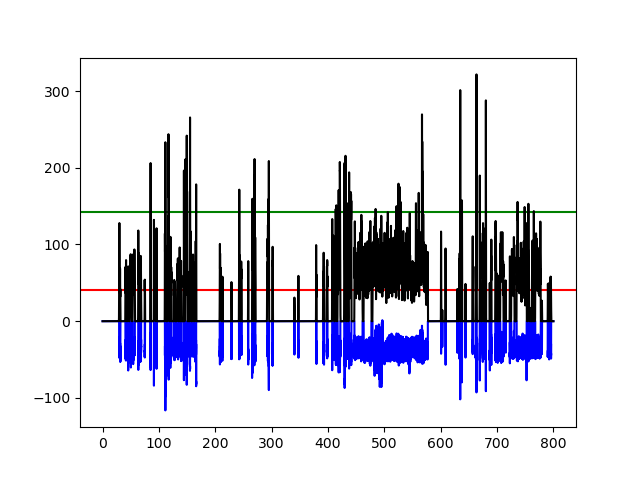

In [139]:
if ResetAnalysis: 
    # Defining subset
    start = 00000
    end = 800000

    times = np.arange(0, CTX.size/fs, 1./fs)
    tt = times[start:end]
    Cortext = wake0C[start:end]/10
    #Cortexcwtt = PFCNWcwt[:, start:end]
    proj_Cortexcwtt = proj_W0Ccwt[start:end]

    plt.close('all')
    plt.axhline(sdproj_cwt, color='r') # horizontal
    plt.axhline(sdproj_cwt*3.5, color='g') # horizontal
    plt.plot(tt, Cortext,'b')
    plt.plot(tt, proj_Cortexcwtt,'k')
    plt.show()

In [140]:
if ResetAnalysis: 
    sd_thresh = sdproj_cwt*4

Display with ephyviewer, not needed

## Extracting Spindles and determining main properties 

First extraction of spindle peaks, initiation, end and width

In [141]:
if ResetAnalysis: 
    proj_cortex = proj_W0Lcwt
    proj_cortexC = proj_W0Ccwt
    sd_proj_cortex = sd_thresh
    lib_wake0_cortex = cwtWake0lib
    filt_cortex = filt

    peaks, properties = find_peaks(proj_cortex, prominence=1, width=200, height=sd_proj_cortex)
    properties["prominences"], properties["widths"]

    # Spindles boundaries taken at 70% from peak of intensity. This means that the spindles with small amplitude will be longer than the big ones.
    results_width = peak_widths(proj_cortex, peaks, rel_height=0.6)

    # Organise results in numpy array
    peaks2 = peaks.reshape(len(peaks),1)
    npresults_width = np.array(results_width).reshape(4,-1)
    Spindle_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()
    print(peaks.shape)

(234,)


Second extraction of main frequency and power 

In [142]:
if ResetAnalysis: 
    
    projMaxP_cwtmg = np.max(lib_wake0_cortex, axis = 0)
    projMaxF_cwtmg = np.argmax(lib_wake0_cortex, axis = 0)/2 + 8
    projMaxP_cwtmg.shape

    nb_Spindles = len(peaks)
    data = np.zeros((nb_Spindles,4))

    for tt in np.arange(nb_Spindles):
        Spindle_start = int(Spindle_prop[3,tt])
        Spindle_stop = int(Spindle_prop[4,tt])
        Spindle_MaxP = projMaxP_cwtmg[Spindle_start:Spindle_stop]
        Spindle_MaxF = projMaxF_cwtmg[Spindle_start:Spindle_stop]
        data[tt, 0] = max(Spindle_MaxF).round()
        data[tt, 1] = max(Spindle_MaxP).round()
        data[tt, 2] = round(sum(Spindle_MaxF)/len(Spindle_MaxF))
        data[tt, 3] = round(sum(Spindle_MaxP)/len(Spindle_MaxP))

    param_Spindle = pd.DataFrame(data, columns = ['Max freq', 'Max int', 'Avg freq', 'Avg int'])
    tSpindle_prop = Spindle_prop.transpose()
    pd_prop_Spindle = pd.DataFrame(tSpindle_prop, columns = ['peak time', 'Duration', 'peak amp', 'start time', 'end time'])
    pd_tokeep = pd.DataFrame(np.ones(nb_Spindles).astype(bool), columns = ['toKeep'])
    All_Spindle = pd.concat([pd_tokeep,pd_prop_Spindle, param_Spindle], axis=1)

C:\Users\Manip2\AppData\Local\Temp\ipykernel_1712108\1544098665.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 1] = max(Spindle_MaxP).round()
C:\Users\Manip2\AppData\Local\Temp\ipykernel_1712108\1544098665.py:18: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  data[tt, 3] = round(sum(Spindle_MaxP)/len(Spindle_MaxP))
C:\Users\Manip2\AppData\Local\Temp\ipykernel_1712108\1544098665.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 3] = round(sum(Spindle_MaxP)/len(Spindle_MaxP))


In [143]:
if ResetAnalysis: 
    nb_spindle = All_Spindle.shape[0]
    listtodrop = []
    for tt in range(nb_spindle-1):
        # merge spdl that starts within a spdl
        if(All_Spindle['end time'][tt]>All_Spindle['start time'][tt + 1]):
            if(All_Spindle['Duration'][tt]<All_Spindle['Duration'][tt + 1]):
                if(All_Spindle['start time'][tt]<All_Spindle['start time'][tt + 1]):
                    All_Spindle['start time'][tt+1] = All_Spindle['start time'][tt]
                    listtodrop.append(tt)
                else:
                    listtodrop.append(tt)
            if(All_Spindle['Duration'][tt]>All_Spindle['Duration'][tt + 1]):
                if(All_Spindle['end time'][tt]<All_Spindle['end time'][tt + 1]):
                    All_Spindle['end time'][tt] = All_Spindle['end time'][tt + 1]
                    listtodrop.append(tt+1)
                else:
                    listtodrop.append(tt+1)

    for tt in range(nb_spindle-1):
        # merge spdls that are 200ms apart
        if((All_Spindle['start time'][tt + 1] - All_Spindle['end time'][tt])<200):
            if((All_Spindle['Duration'][tt])<All_Spindle['Duration'][tt + 1]): #first spdl longer so remove/merge the second one
                All_Spindle['start time'][tt + 1] = All_Spindle['start time'][tt]
                listtodrop.append(tt)
            if((All_Spindle['Duration'][tt+1])<All_Spindle['Duration'][tt]): #second spdl longer so remove/merge the first one
                All_Spindle['end time'][tt] = All_Spindle['start time'][tt + 1]
                listtodrop.append(tt+1)

    for tt in range(nb_spindle):
        #Update duration because of the merging
        All_Spindle['Duration'][tt]=All_Spindle['end time'][tt]-All_Spindle['start time'][tt]

    for tt in range(nb_spindle): #All_Spindle.index:
        #Remove Spdl that last than 500ms
        if (All_Spindle['Duration'][tt]<500):
            listtodrop.append(tt)

    print('Nb of Spdl detected:', len(All_Spindle))    
    All_Spindle = All_Spindle.drop(listtodrop) 
    print('Nb of Spdl detected after merging:', len(All_Spindle))    

    #All_Spindle.to_pickle(filenameOutput2)
    All_Spindle.to_csv(filenameOutput3, sep= ',')

Nb of Spdl detected: 234
Nb of Spdl detected after merging: 116


C:\Users\Manip2\AppData\Local\Temp\ipykernel_1712108\1302312933.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  All_Spindle['start time'][tt + 1] = All_Spindle['start time'][tt]
C:\Users\Manip2\AppData\Local\Temp\ipykernel_1712108\1302312933.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  All_Spindle['end time'][tt] = All_Spindle['start time'][tt + 1]
C:\Users\Manip2\AppData\Local\Temp\ipykernel_1712108\1302312933.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

### Display

ephys viewer to check Spindle detection

In [144]:
%gui qt

app = mkQApp()

#Create one data source with 3 event channel
all_events = []
conditions = ['All','Good','Bad']
for c,cond in enumerate(conditions):
    match cond:
        case 'All':
            selection = "All_Spindle['toKeep'] | ~All_Spindle['toKeep']"
        case 'Good':
            selection = "All_Spindle['toKeep']"
        case 'Bad':
            selection = "~All_Spindle['toKeep']"
    ev_times = All_Spindle.loc[pd.eval(selection),'peak time'].values/1000
    ev_labels = [f'spindle {i}'for i in All_Spindle[pd.eval(selection)].index]
    all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
source_ev = InMemoryEventSource(all_events=all_events)


sample_rate = 1000.
t_start = 0.

combined = np.stack([CTX, filt_cortex, proj_cortexC, proj_cortex, EMG], axis = 1)

Spindle_peak = np.array(All_Spindle['peak time']).astype(int)
Spindle_start = np.array(All_Spindle['start time']).astype(int) # Spindle_prop[3,:].astype(int)
Spindle_end = np.array(All_Spindle['end time']).astype(int) #Spindle_prop[4,:].astype(int)

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: Spindle_peak, 1: Spindle_start, 2: Spindle_end}
#and asign them to some channels each
scatter_channels = {0: [], 1: [0, 1], 2: [0, 1]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#FFFFFF', 2: '#222222'}, channel_names=[f'{structure}','FiltLFP', 'EMGLib', 'EMGCons', 'EMG'])

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
view1.auto_scale()

nCh = len(view1.by_channel_params.children())
mult = 5
for ch in range(nCh):
    match ch%mult:
        case 0: # raw traces
            view1.by_channel_params[f'ch{ch}', 'offset'] = 1 + 3*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.05
            view1.by_channel_params[f'ch{ch}', 'color'] = '#88FF88'
        case 1: # filtered traces
            view1.by_channel_params[f'ch{ch}', 'offset'] = .5 + 3*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#0055ff'
        case 2: # envelop
            view1.by_channel_params[f'ch{ch}', 'offset'] = .5 + 3*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#ff5500'
        case 3: # envelop
            view1.by_channel_params[f'ch{ch}', 'offset'] = .5 + 3*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#ffffff'
        case 4: # EMG
            view1.by_channel_params[f'ch{ch}', 'offset'] = .2 + 3*int(ch/mult)
            view1.by_channel_params[f'ch{ch}', 'gain'] = 1/10000
            view1.by_channel_params[f'ch{ch}', 'color'] = '#888888'
view1.params['ylim_max']=1.5*int((nCh+1)/mult)
view1.params['ylim_min']=0

view2 = EventList(source=source_ev, name='event')


#create a time freq viewer conencted to the same source
view3 = TimeFreqViewer(source=source, name='FFT')
view3.params['show_axis'] = True
view3.params['timefreq', 'f_start'] = 1
view3.params['timefreq', 'f_stop'] = 30
view3.params['timefreq', 'deltafreq'] = 1 #interval in Hz
view3.by_channel_params['ch0', 'clim'] = 300
view3.by_channel_params['ch0', 'visible'] = True


#put this viewer in the main window
win.add_view(view1)
win.add_view(view3)
win.add_view(view2, location='bottom',  orientation='horizontal')

#Run
win.show()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s


#### Select and deselect spindles

In [145]:
def clicked(arg):
    selectedEvent = view2.list_widget.currentItem().text()
    selectedSpindle = int(selectedEvent.split('spindle')[1])
    #print(selectedSpindle)
    match arg.description:
        case 'Keep spindle':
            All_Spindle.loc[selectedSpindle,'toKeep']=True
            print(f'Spindle {selectedSpindle} restored')
        case 'Discard spindle':
            All_Spindle.loc[selectedSpindle,'toKeep']=False
            print(f'Spindle {selectedSpindle} discarded')
    #save modif
    #All_Spindle.to_pickle(filenameOutput2)
    All_Spindle.to_csv(filenameOutput3, sep= ',')
    #Create one data source with 3 event channel
    all_events = []
    conditions = ['All','Good','Bad']
    for c,cond in enumerate(conditions):
        match cond:
            case 'All':
                selection = "All_Spindle['toKeep'] | ~All_Spindle['toKeep']"
            case 'Good':
                selection = "All_Spindle['toKeep']"
            case 'Bad':
                selection = "~All_Spindle['toKeep']"
        ev_times = All_Spindle.loc[pd.eval(selection),'peak time'].values/1000
        ev_labels = [f'spindle {i}'for i in All_Spindle[pd.eval(selection)].index]
        all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
    source_ev = InMemoryEventSource(all_events=all_events)
    view2.source = source_ev
    view2.refresh_list(view2.combo.currentIndex())

button_Good = widgets.Button(description = 'Keep spindle')   
button_Good.on_click(clicked)

button_Bad = widgets.Button(description = 'Discard spindle')   
button_Bad.on_click(clicked)

display(button_Good, button_Bad)

Button(description='Keep spindle', style=ButtonStyle())

Button(description='Discard spindle', style=ButtonStyle())

Spindle 5 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.0003917217254638672 s
refresh duration for event 0.0 s
refresh duration for  0.0045146942138671875 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
Spindle 6 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
Spindle 8 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.0007653236389160156 s
refresh duration for event 0.0 s
Spindle 9 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.0009064674377441406 s
refresh duration for event 0.0 s
Spindle 17 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.0015001296997070312 s
refresh duration for event 0.0 s
Spindle 20 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
Spindle 21 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.001516103744506836 s
refresh duration for event 0.0 s
Spindle 22 dis

AttributeError: 'NoneType' object has no attribute 'text'

refresh duration for  0.0009999275207519531 s
refresh duration for FFT 0.0005044937133789062 s
refresh duration for event 0.0 s
Spindle 121 discarded


AttributeError: 'NoneType' object has no attribute 'text'

refresh duration for  0.0015535354614257812 s
refresh duration for FFT 0.0010063648223876953 s
refresh duration for event 0.0 s
Spindle 123 discarded
refresh duration for  0.0005085468292236328 s
refresh duration for FFT 0.0007658004760742188 s
refresh duration for event 0.0 s
Spindle 124 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
Spindle 125 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.0010004043579101562 s
refresh duration for event 0.0 s
refresh duration for  0.0015361309051513672 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
Spindle 130 discarded
refresh duration for  0.001520395278930664 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
Spindle 132 discarded
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
Spindle 133 discarded
refresh